# $2\mathrm{P}~\mathrm{Correlation~Function}$: $\mathrm{Varying}~\omega_m$

## Packages

In [1]:
import numpy as np
from classy import Class


import scipy 
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

import hankl
import math

# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 16
})

## Compute $P(k)$ from CLASS

In [2]:
# Grid of 4x4 
omega_b_vals = np.linspace(0.0214, 0.0234, 4)
omega_m_vals = np.linspace(0.13, 0.15, 4)
# To store models
Model = {}

In [3]:
for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        cosmo_params = {'omega_b': omega_b_vals[i], 'omega_cdm': omega_m_vals[j] - omega_b_vals[i], 'h': 0.67810, 'A_s': 2.100549e-09,
                        'n_s': 0.9660499, 'output': 'mPk', 'P_k_max_1/Mpc': 3.0}
        Model[i, j] = Class()
        Model[i, j].set(cosmo_params)
        Model[i, j].compute()
print('Run Class... Done')

Run Class... Done


In [4]:
Theta = 1.01037 # Related to CMB temperature
e = math.exp(1) # Euler constant
h = 0.67810
ns = 0.9660499
As = 2.100549

In [5]:
# Get P(k) at z = 0
kk = np.logspace(-4, np.log10(3), 20000)  # k in [1/Mpc]
Pk = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]  # P(k) in [Mpc^3]
interpolated_Pk = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]

for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        # Extract the correct model from the Model list
        Pk[i][j] = [Model[i, j].pk(k*h, 0.)*h**3 for k in kk]  # total matter P(k) in [Mpc/h]^3 for given k in [h/Mpc]
        
        # Interpolate {k, P(k)}
        interpolated_Pk[i][j] = scipy.interpolate.interp1d(kk, Pk[i][j], kind='cubic', fill_value='extrapolate')

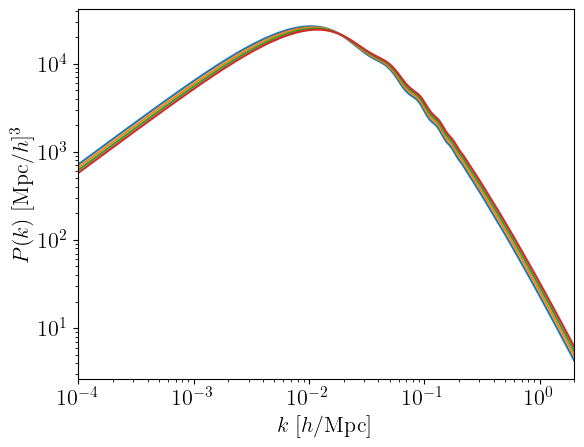

In [6]:
# plot P(k)
plt.xscale('log')
plt.yscale('log')
plt.xlim(kk[0], 2)
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \ [\mathrm{Mpc}/h]^3$')
for i in range(len(omega_m_vals)):
    plt.plot(kk*h, interpolated_Pk[0][i](kk))
plt.show()

## Compute $P_\mathrm{EH}(k)$

In [8]:
def sh(omega_b_index, omega_m_index):
    sh_calc = 44.5*np.log(9.83/omega_m_vals[omega_m_index])/(np.sqrt(1 + 10*omega_b_vals[omega_b_index]**(3/4)))
    return sh_calc

def alpha_Gamma(omega_b_index, omega_m_index):
    alpha_Gamma_calc = 1 - 0.328*np.log(431*omega_m_vals[omega_m_index])*(omega_b_vals[omega_b_index]/omega_m_vals[omega_m_index]) + 0.38*np.log(22.3*omega_m_vals[omega_m_index])*(omega_b_vals[omega_b_index]/omega_m_vals[omega_m_index])**2
    return alpha_Gamma_calc

def Gamma_eff(k, omega_b_index, omega_m_index):
    Gamma_eff_calc = (omega_m_vals[omega_m_index]/h)*(alpha_Gamma(omega_b_index, omega_m_index) + (1 - alpha_Gamma(omega_b_index, omega_m_index))/(1 + (0.43*k*sh(omega_b_index, omega_m_index))**4))
    return Gamma_eff_calc

def q_eff(k, omega_b_index, omega_m_index):
    q_eff_calc = (k/h)*(Theta**2/Gamma_eff(k, omega_b_index, omega_m_index))
    return q_eff_calc

def L0_eff(k, omega_b_index, omega_m_index):
    L0_eff_calc = np.log(2*e + 1.8*q_eff(k, omega_b_index, omega_m_index))
    return L0_eff_calc

def C0_eff(k, omega_b_index, omega_m_index):
    C0_eff_calc = 14.2 + (731/(1 + 62.5*q_eff(k, omega_b_index, omega_m_index)))
    return C0_eff_calc

def TEHnw(k, omega_b_index, omega_m_index):
    TEHnw_calc = L0_eff(k, omega_b_index, omega_m_index)/(L0_eff(k, omega_b_index, omega_m_index) + C0_eff(k, omega_b_index, omega_m_index)*q_eff(k, omega_b_index, omega_m_index)**2)
    return TEHnw_calc

def PEHnw(k, omega_b_index, omega_m_index):
    PEHnw_calc = Amp_EH[omega_b_index][omega_m_index]*(k**ns)*TEHnw(k*h, omega_b_index, omega_m_index)**2
    return PEHnw_calc

In [9]:
# Sigma_8 values: modelo CLASS previamente generado para cada combinación
sigma8_vals = np.zeros((len(omega_b_vals), len(omega_m_vals)))

# Asumes que tienes Model[(i, j)] guardado para cada par (omega_b_index, omega_m_index)
for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        sigma8_vals[i][j] = Model[(i, j)].sigma8()

In [10]:
R8 = 8.0
def W_top_hat(x):
    return 3 * (np.sin(x) - x * np.cos(x)) / x**3

In [11]:
def integral_EH(omega_b_index, omega_m_index):
    def integrand(k):
        T = TEHnw(k*h, omega_b_index, omega_m_index)
        W = W_top_hat(k * R8)
        return k**(ns + 2) * T**2 * W**2
    result, _ = integrate.quad(integrand, 1e-5, 10, epsabs=1e-6, limit=100)
    return result

# Matriz de normalización
Amp_EH = np.zeros((len(omega_b_vals), len(omega_m_vals)))

for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        I = integral_EH(i, j)
        Amp_EH[i][j] = 2 * np.pi**2 * sigma8_vals[i][j]**2 / I

In [12]:
def sigma8_EH(i, j):
    def integrand(k):
        P = PEHnw(k, i, j)
        W = W_top_hat(k * R8)
        return k**2 * P * W**2
    result, _ = integrate.quad(integrand, 1e-5, 10, epsabs=1e-6, limit=100)
    return np.sqrt(result / (2 * np.pi**2))

# Comparar para algunos pares
for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        sigma_true = sigma8_vals[i][j]
        sigma_model = sigma8_EH(i, j)
        print(f"[i={i}, j={j}]: σ₈ EH = {sigma_model:.6f}, σ₈ CLASS = {sigma_true:.6f}")

[i=0, j=0]: σ₈ EH = 0.780022, σ₈ CLASS = 0.779960
[i=0, j=1]: σ₈ EH = 0.810391, σ₈ CLASS = 0.810325
[i=0, j=2]: σ₈ EH = 0.839427, σ₈ CLASS = 0.839359
[i=0, j=3]: σ₈ EH = 0.867199, σ₈ CLASS = 0.867131
[i=1, j=0]: σ₈ EH = 0.772480, σ₈ CLASS = 0.772413
[i=1, j=1]: σ₈ EH = 0.802941, σ₈ CLASS = 0.802870
[i=1, j=2]: σ₈ EH = 0.832066, σ₈ CLASS = 0.831993
[i=1, j=3]: σ₈ EH = 0.859934, σ₈ CLASS = 0.859861
[i=2, j=0]: σ₈ EH = 0.764989, σ₈ CLASS = 0.764916
[i=2, j=1]: σ₈ EH = 0.795536, σ₈ CLASS = 0.795460
[i=2, j=2]: σ₈ EH = 0.824753, σ₈ CLASS = 0.824676
[i=2, j=3]: σ₈ EH = 0.852711, σ₈ CLASS = 0.852634
[i=3, j=0]: σ₈ EH = 0.757547, σ₈ CLASS = 0.757470
[i=3, j=1]: σ₈ EH = 0.788181, σ₈ CLASS = 0.788100
[i=3, j=2]: σ₈ EH = 0.817483, σ₈ CLASS = 0.817401
[i=3, j=3]: σ₈ EH = 0.845531, σ₈ CLASS = 0.845450


<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_4120606/1097719864.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathrm{Eisenstein-Hu}$')


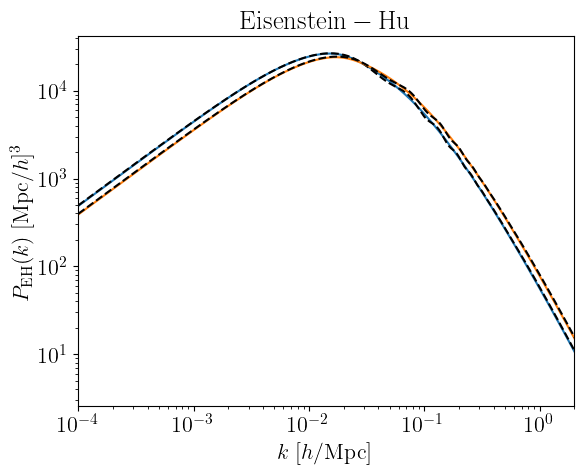

In [13]:
# plot P(k)
plt.xscale('log')
plt.yscale('log')
plt.xlim(kk[0], 2)
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_\mathrm{EH}(k) \ [\mathrm{Mpc}/h]^3$')
plt.title('$\mathrm{Eisenstein-Hu}$')
plt.plot(kk, PEHnw(kk, 0, 0), '-')
plt.plot(kk, interpolated_Pk[0][0](kk), '--', color='black')
plt.plot(kk, PEHnw(kk, 0, 3), '-')
plt.plot(kk, interpolated_Pk[0][3](kk), '--', color='black')
plt.show()

## $P(k)$ from GAs

In [14]:
from scipy.special import erf

def Tw(k, omega_b_index, omega_m_index):
    term1 = np.exp(-0.6398778965718964 * (k / (omega_b_vals[omega_b_index]**0.52 * (1 + 0.1080981664770769 / omega_m_vals[omega_m_index]**0.95) * omega_m_vals[omega_m_index]**0.73))**0.9499456592567621)
    term2 = 0.19012006269148962 - 0.23344193339279928 * omega_b_vals[omega_b_index]**0.6148785478414289 + 0.053292505303927706 * omega_m_vals[omega_m_index]**1.3823117503453435
    sin_term = np.sin((0.7464952519313522 * k) / ((1.238401498145667 + 0.0003460661548869367 * (((0.00785436 * omega_b_vals[omega_b_index]**0.177084 + 0.00912388 * omega_m_vals[omega_m_index]**0.618711 + 11.9611 * omega_b_vals[omega_b_index]**2.81343 * omega_m_vals[omega_m_index]**0.784719) * omega_m_vals[omega_m_index]**0.999364044387969) / k)**3.494331677399285)**0.3118331040326223 * (0.00785436 * omega_b_vals[omega_b_index]**0.177084 + 0.00912388 * omega_m_vals[omega_m_index]**0.618711 + 11.9611 * omega_b_vals[omega_b_index]**2.81343 * omega_m_vals[omega_m_index]**0.784719)))
    term3 = 1.4367875114902346 + (1 / k * (0.00785436 * omega_b_vals[omega_b_index]**0.177084 + 0.00912388 * omega_m_vals[omega_m_index]**0.618711 + 11.9611 * omega_b_vals[omega_b_index]**2.81343 * omega_m_vals[omega_m_index]**0.784719) * (1.3470299397073937 - 31.752524962256118 * omega_b_vals[omega_b_index]**1.224379477527699 + 57.73638905940291 * omega_m_vals[omega_m_index]**1.047482937614228))**2.865382948545329
    return 1 + term1 * term2 * sin_term / term3

def Tnw(k, omega_b_index, omega_m_index):
    x = k / (omega_m_vals[omega_m_index] - omega_b_vals[omega_b_index])
    term1 = 59.09983473000389 * x**1.4917653903428132
    term2 = 4658.007645250978 * x**4.027553399922359
    term3 = 3170.788890492977 * x**6.060004349851289
    term4 = 150.08874315951203 * x**7.284778673036612
    return (1 + term1 + term2 + term3 + term4)**(-1/4)

def TGAs(k, omega_b_index, omega_m_index):
    return Tnw(k, omega_b_index, omega_m_index) * Tw(k, omega_b_index, omega_m_index)

def PGAs_nw(k, omega_b_index, omega_m_index):
    PGAs_nw_calc = Amp_GAs[omega_b_index][omega_m_index]*(k**ns)*Tnw(k, omega_b_index, omega_m_index)**2
    return PGAs_nw_calc

def PGAs(k, omega_b_index, omega_m_index):
    PGAs_calc = Amp_GAs[omega_b_index][omega_m_index]*(k**ns)*TGAs(k, omega_b_index, omega_m_index)**2
    return PGAs_calc

In [15]:
def integral_GA(i, j):
    def integrand(k):
        T = Tnw(k, i, j)
        W = W_top_hat(k * R8)
        return k**(ns + 2) * T**2 * W**2
    result, _ = integrate.quad(integrand, 1e-5, 10, epsabs=1e-6, limit=100)
    return result

Amp_GAs = np.zeros((len(omega_b_vals), len(omega_m_vals)))

for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        I = integral_GA(i, j)
        Amp_GAs[i][j] = 2 * np.pi**2 * sigma8_vals[i][j]**2 / I

In [16]:
def sigma8_GA(i, j):
    def integrand(k):
        P = PGAs(k, i, j)
        W = W_top_hat(k * R8)
        return k**2 * P * W**2
    result, _ = integrate.quad(integrand, 1e-5, 10, epsabs=1e-6, limit=100)
    return np.sqrt(result / (2 * np.pi**2))

# Comparar
for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        s_true = sigma8_vals[i][j]
        s_GA = sigma8_GA(i, j)
        print(f"[{i},{j}]  σ₈ GA = {s_GA:.6f},  σ₈ CLASS = {s_true:.6f},  Δ = {abs(s_GA - s_true)/s_true*100:.2f}%")

[0,0]  σ₈ GA = 0.779936,  σ₈ CLASS = 0.779960,  Δ = 0.00%
[0,1]  σ₈ GA = 0.810331,  σ₈ CLASS = 0.810325,  Δ = 0.00%
[0,2]  σ₈ GA = 0.839393,  σ₈ CLASS = 0.839359,  Δ = 0.00%
[0,3]  σ₈ GA = 0.867192,  σ₈ CLASS = 0.867131,  Δ = 0.01%
[1,0]  σ₈ GA = 0.772390,  σ₈ CLASS = 0.772413,  Δ = 0.00%
[1,1]  σ₈ GA = 0.802877,  σ₈ CLASS = 0.802870,  Δ = 0.00%
[1,2]  σ₈ GA = 0.832029,  σ₈ CLASS = 0.831993,  Δ = 0.00%
[1,3]  σ₈ GA = 0.859923,  σ₈ CLASS = 0.859861,  Δ = 0.01%
[2,0]  σ₈ GA = 0.764894,  σ₈ CLASS = 0.764916,  Δ = 0.00%
[2,1]  σ₈ GA = 0.795468,  σ₈ CLASS = 0.795460,  Δ = 0.00%
[2,2]  σ₈ GA = 0.824712,  σ₈ CLASS = 0.824676,  Δ = 0.00%
[2,3]  σ₈ GA = 0.852697,  σ₈ CLASS = 0.852634,  Δ = 0.01%
[3,0]  σ₈ GA = 0.757448,  σ₈ CLASS = 0.757470,  Δ = 0.00%
[3,1]  σ₈ GA = 0.788108,  σ₈ CLASS = 0.788100,  Δ = 0.00%
[3,2]  σ₈ GA = 0.817438,  σ₈ CLASS = 0.817401,  Δ = 0.00%
[3,3]  σ₈ GA = 0.845513,  σ₈ CLASS = 0.845450,  Δ = 0.01%


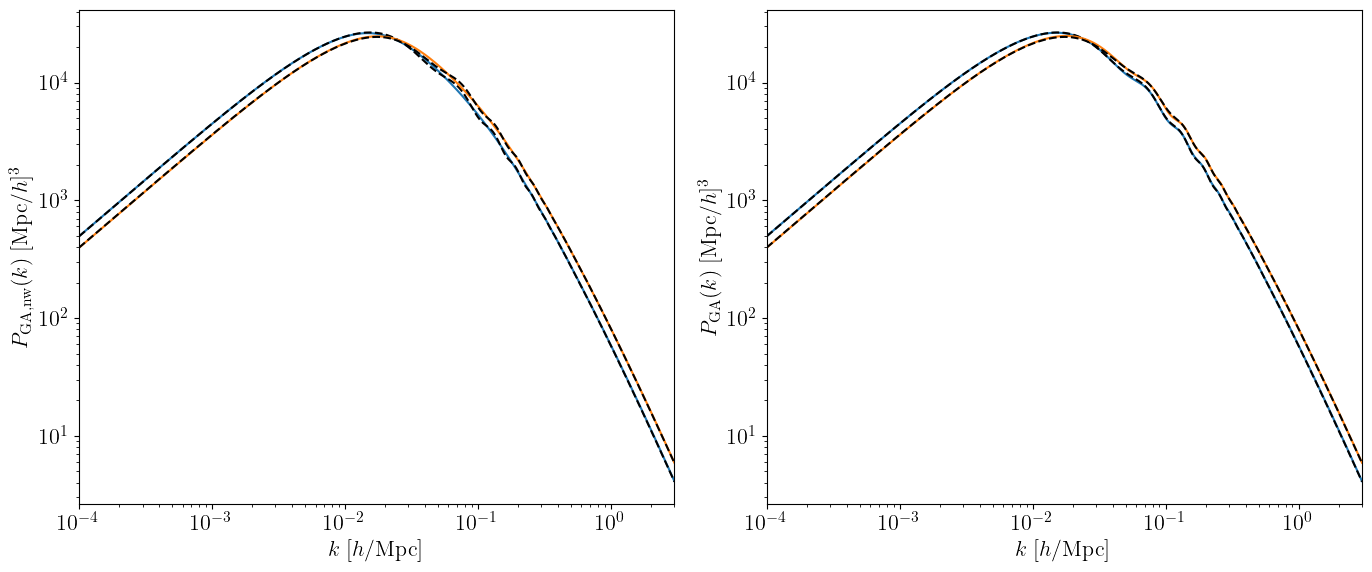

In [19]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot PGAs(k)
ax1.plot(kk, PGAs_nw(kk, 0, 0), '-')
ax1.plot(kk, interpolated_Pk[0][0](kk), '--', color='black')
ax1.plot(kk, PGAs_nw(kk, 0, 3), '-')
ax1.plot(kk, interpolated_Pk[0][3](kk), '--', color='black')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(kk[0], kk[-1])
ax1.set_xlabel(r'$k \ [h/\mathrm{Mpc}]$')
ax1.set_ylabel(r'$P_\mathrm{GA, nw}(k) \ [\mathrm{Mpc}/h]^3$')

# Plot PGAs(k)
ax2.plot(kk, PGAs(kk, 0, 0), '-')
ax2.plot(kk, interpolated_Pk[0][0](kk), '--', color='black')
ax2.plot(kk, PGAs(kk, 0, 3), '-')
ax2.plot(kk, interpolated_Pk[0][3](kk), '--', color='black')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(kk[0], kk[-1])
ax2.set_xlabel(r'$k \ [h/\mathrm{Mpc}]$')
ax2.set_ylabel(r'$P_\mathrm{GA}(k) \ [\mathrm{Mpc}/h]^3$')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## $\xi_\text{2PT}$ from CLASS+EH

In [107]:
def Olin_EH(k, omega_b_index, omega_m_index):
    Olin_EH_calc = interpolated_Pk[omega_b_index][omega_m_index](k)/PEHnw(k, omega_b_index, omega_m_index)
    return Olin_EH_calc

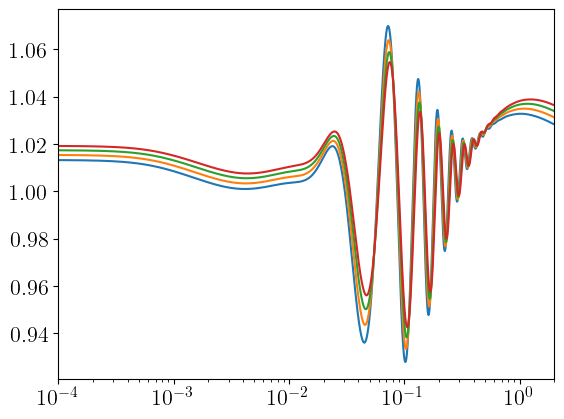

In [110]:
# plot P(k)
plt.xscale('log')
plt.xlim(kk[0], 2)
for i in range(len(omega_m_vals)):
    plt.plot(kk, Olin_EH(kk, 1, i), '-')
plt.show()

In [192]:
bias_0 = 1.0
s8_0 = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]
for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        s8_0[i][j] = Model[i, j].sigma8()
alpha_par = 1.0
alpha_trans = 1.0

In [193]:
# AP correction
def kpar(k, mu):
    return k*mu/alpha_par

def kper(k, mu):
    return k*np.sqrt(1 - mu**2)/alpha_trans

#This is the k with AP included
def kap(k, mu):
    return np.sqrt(kpar(k, mu)**2 + kper(k, mu)**2)

#This is the mu with AP included
def muap(k, mu):
    return kpar(k, mu)/kap(k, mu)

def growthrate(z):
    growthrate_class = 1.0
    return growthrate_class
        
def finger(k, mu, sigmas):
    finger_calc = (1 + (k*sigmas*mu)**2)**(-1)
    return finger_calc

def fs8(z, omega_b_index, omega_m_index):
    fs8_calc = s8_0[omega_b_index][omega_m_index]*growthrate(z)
    return fs8_calc

In [111]:
# Zel’dovich approximation 
def sigmaxy_class(omega_b_index, omega_m_index):
    kgrid1 = np.linspace(np.log(kk[0]), np.log(kk[-1]), 2**12+1)
    dk = np.diff(kgrid1)[0] 
    I1 = np.cumsum(dk*np.exp(kgrid1)*interpolated_Pk[omega_b_index][omega_m_index](np.exp(kgrid1)))
    sigmaxy_calc = s8_0[omega_b_index][omega_m_index]*np.sqrt(I1[-1]/(2*np.pi**2))
    return sigmaxy_calc

def sigmaz_class(z, omega_b_index, omega_m_index): 
    sigmaz_calc = (1+growthrate(z))*sigmaxy_class(omega_b_index, omega_m_index)
    return sigmaz_calc

def sigmanl_class(z, omega_b_index, omega_m_index):
    sigmanl_calc = np.sqrt(2/3*sigmaxy_class(omega_b_index, omega_m_index)**2 + 1/3*sigmaz_class(z, omega_b_index, omega_m_index)**2)
    return sigmanl_calc

def expgmu_class(k, omega_b_index, omega_m_index):
    expgmu_calc = np.exp(-0.5* sigmanl_class(0, omega_b_index, omega_m_index)**2*k**2)    
    return expgmu_calc

In [112]:
def pksmooth_class(k, mu, sigmas, omega_b_index, omega_m_index):
    rsmooth = 15
    recon = 1 - np.exp(-0.5*(k*rsmooth)**2)
    kaiser = (s8_0[omega_b_index][omega_m_index]*bias_0 + fs8(0, omega_b_index, omega_m_index)*recon*mu**2)**2
    fog = finger(k, mu, sigmas)
    pksmooth_calc = kaiser*fog*PEHnw(k, omega_b_index, omega_m_index)
    return pksmooth_calc

#The observed Galaxy power spectrum
def pobs_class(k, mu, sigmas, omega_b_index, omega_m_index):
    term = 1 + (Olin_EH(kap(k, mu), omega_b_index, omega_m_index) - 1)*expgmu_class(kap(k, mu), omega_b_index, omega_m_index)
    pobs_class_calc = pksmooth_class(kap(k, mu), muap(k, mu), sigmas, omega_b_index, omega_m_index)*term
    return pobs_class_calc

In [113]:
n_step_mu_int = 16
n_step_k_int = n_step_mu_int
k_range = np.logspace(np.log10(10**-3), np.log10(10), 500)

def pkell_0_1_class(k, sigmas, omega_b_index, omega_m_index):
    mugrid1 = np.linspace(-1, 1, 2**n_step_mu_int+1)
    dmu = np.diff(mugrid1)[0]
    pobsgrid = pobs_class(k, mugrid1, sigmas, omega_b_index, omega_m_index)
    I1 = np.cumsum(dmu*pobsgrid)
    pkell_0_1_class_calc = I1[-1]/2
    return pkell_0_1_class_calc

pkell_0_class = np.vectorize(pkell_0_1_class)

s0_class = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]
xi0_class = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]

for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        s0_class[i][j], xi0_class[i][j] = hankl.P2xi(k_range, pkell_0_class(k_range, 0, i, j), l=0)

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_4120606/2213751899.py:5: SyntaxWarning: invalid escape sequence '\o'
  ax1.plot(s0_class[1][i], s0_class[1][i]**2*xi0_class[1][i], label=f'$\omega_m = {omega_m_vals[i]:.3f}$')
/tmp/ipykernel_4120606/2213751899.py:19: SyntaxWarning: invalid escape sequence '\o'
  ax2.plot(s0_class[i][1], s0_class[i][1]**2*xi0_class[i][1], label=f'$\omega_b = {omega_b_vals[i]:.3f}$')
/home/bayron/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/bayron/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


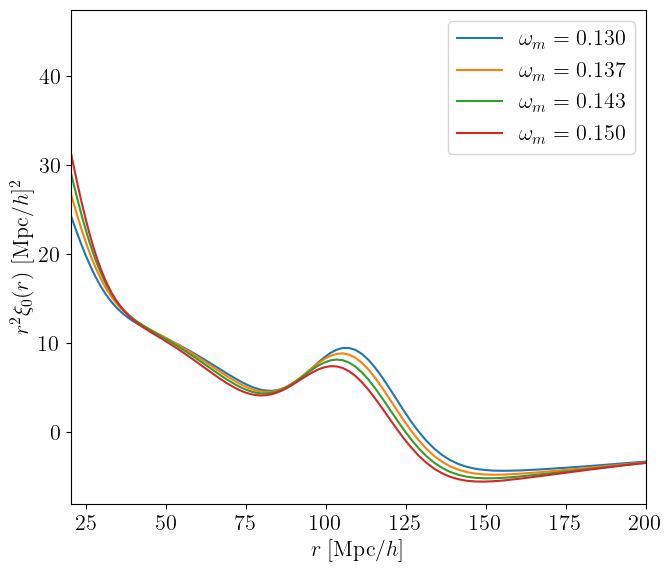

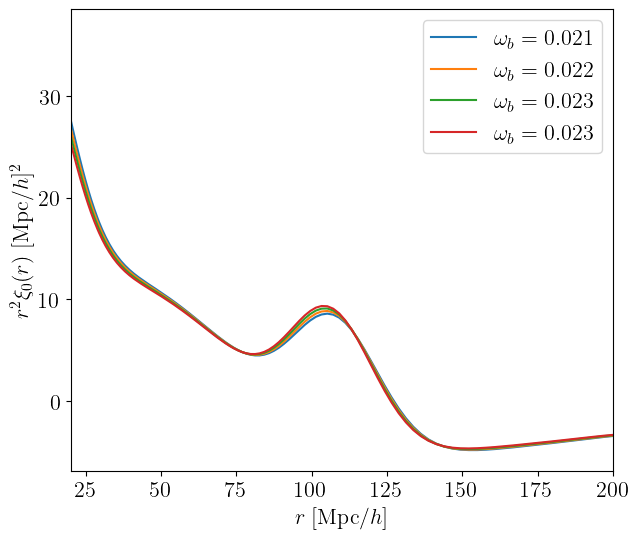

In [114]:
# Create the first figure and axis
fig1, ax1 = plt.subplots(figsize=(7, 6))

for i in range(len(omega_m_vals)):
    ax1.plot(s0_class[1][i], s0_class[1][i]**2*xi0_class[1][i], label=f'$\omega_m = {omega_m_vals[i]:.3f}$')
ax1.set_xlim(20, 200)
ax1.set_xlabel(r'$r \ [\mathrm{Mpc}/h]$')
ax1.set_ylabel(r'$r^2 \xi_0 (r) \ [\mathrm{Mpc}/h]^2$')
ax1.legend()

# Save the first plot as a PDF
fig1.tight_layout()
fig1.savefig('2PCF_EH.pdf')

# Create the second figure and axis
fig2, ax2 = plt.subplots(figsize=(7, 6))

for i in range(len(omega_b_vals)):
    ax2.plot(s0_class[i][1], s0_class[i][1]**2*xi0_class[i][1], label=f'$\omega_b = {omega_b_vals[i]:.3f}$')
ax2.set_xlim(20, 200)
ax2.set_xlabel(r'$r \ [\mathrm{Mpc}/h]$')
ax2.set_ylabel(r'$r^2 \xi_0 (r) \ [\mathrm{Mpc}/h]^2$')
ax2.legend()

# Display the plots
plt.show()

## $\xi_\text{2PT}$ from CLASS+GAs

In [115]:
def Olin_GAs(k, omega_b_index, omega_m_index): 
    Olin_GAs_calc = interpolated_Pk[omega_b_index][omega_m_index](k)/PGAs_nw(k, omega_b_index, omega_m_index)
    return Olin_GAs_calc

In [116]:
# Zel’dovich approximation 
def sigmaxy_GAs(omega_b_index, omega_m_index):
    kgrid1 = np.linspace(np.log(kk[0]), np.log(kk[-1]), 2**12+1)
    dk = np.diff(kgrid1)[0] 
    I1 = np.cumsum(dk*np.exp(kgrid1)*PGAs(np.exp(kgrid1), omega_b_index, omega_m_index))
    sigmaxy_calc = s8_0[omega_b_index][omega_m_index]*np.sqrt(I1[-1]/(2*np.pi**2))
    return sigmaxy_calc

def sigmaz_GAs(z, omega_b_index, omega_m_index): 
    sigmaz_calc = (1+growthrate(z))*sigmaxy_GAs(omega_b_index, omega_m_index)
    return sigmaz_calc

def sigmanl_GAs(z, omega_b_index, omega_m_index):
    sigmanl_calc = np.sqrt(2/3*sigmaxy_GAs(omega_b_index, omega_m_index)**2 + 1/3*sigmaz_GAs(z, omega_b_index, omega_m_index)**2)
    return sigmanl_calc

def expgmu_GAs(k, omega_b_index, omega_m_index):
    expgmu_calc = np.exp(-0.5*sigmanl_GAs(0, omega_b_index, omega_m_index)**2*k**2)    
    return expgmu_calc

In [117]:
def pksmooth_GAs(k, mu, sigmas, omega_b_index, omega_m_index):
    rsmooth = 15
    recon = 1 - np.exp(-0.5*(k*rsmooth)**2)
    kaiser = (s8_0[omega_b_index][omega_m_index]*bias_0 + fs8(0, omega_b_index, omega_m_index)*recon*mu**2)**2
    fog = finger(k, mu, sigmas)
    pksmooth_calc = kaiser*fog*PGAs_nw(k, omega_b_index, omega_m_index)
    return pksmooth_calc

#The observed Galaxy power spectrum
def pobs_GAs(k, mu, sigmas, omega_b_index, omega_m_index):
    term = 1 + (Olin_GAs(kap(k, mu), omega_b_index, omega_m_index) - 1)*expgmu_GAs(kap(k, mu), omega_b_index, omega_m_index)
    pobs_GAs_calc = pksmooth_GAs(kap(k, mu), muap(k, mu), sigmas, omega_b_index, omega_m_index)*term
    return pobs_GAs_calc

In [118]:
def pkell_0_1_GAs(k, sigmas, omega_b_index, omega_m_index):
    mugrid1 = np.linspace(-1, 1, 2**n_step_mu_int+1)
    dmu = np.diff(mugrid1)[0]
    pobsgrid = pobs_GAs(k, mugrid1, sigmas, omega_b_index, omega_m_index)
    I1 = np.cumsum(dmu*pobsgrid)
    pkell_0_1_GAs_calc = I1[-1]/2
    return pkell_0_1_GAs_calc

pkell_0_GAs = np.vectorize(pkell_0_1_GAs)

s0_GAs = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]
xi0_GAs = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]

for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        s0_GAs[i][j], xi0_GAs[i][j] = hankl.P2xi(k_range, pkell_0_GAs(k_range, 0, i, j), l=0)

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_4120606/2042710641.py:5: SyntaxWarning: invalid escape sequence '\o'
  ax1.plot(s0_GAs[1][i], s0_GAs[1][i]**2*xi0_GAs[1][i], label=f'$\omega_m = {omega_m_vals[i]:.3f}$')
/tmp/ipykernel_4120606/2042710641.py:19: SyntaxWarning: invalid escape sequence '\o'
  ax2.plot(s0_GAs[i][1], s0_GAs[i][1]**2*xi0_GAs[i][1], label=f'$\omega_b = {omega_b_vals[i]:.3f}$')


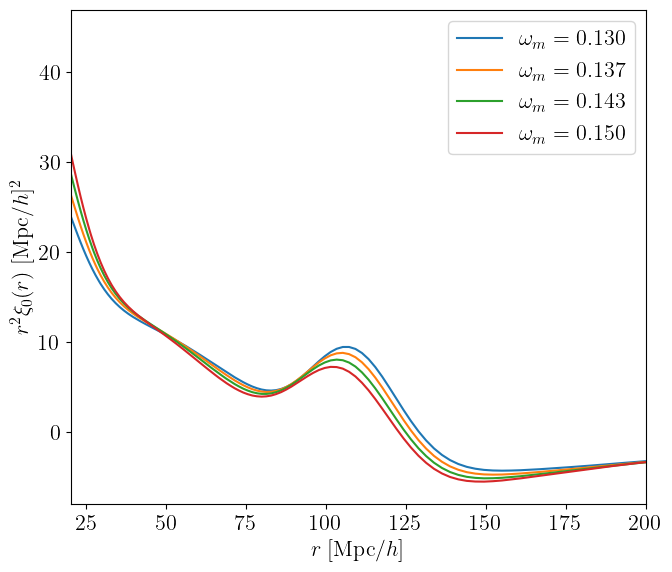

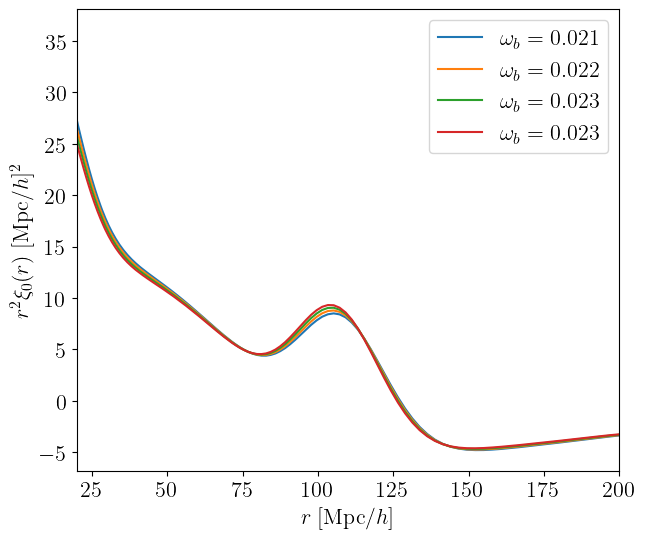

In [119]:
# Create the first figure and axis
fig1, ax1 = plt.subplots(figsize=(7, 6))

for i in range(len(omega_m_vals)):
    ax1.plot(s0_GAs[1][i], s0_GAs[1][i]**2*xi0_GAs[1][i], label=f'$\omega_m = {omega_m_vals[i]:.3f}$')
ax1.set_xlim(20, 200)
ax1.set_xlabel(r'$r \ [\mathrm{Mpc}/h]$')
ax1.set_ylabel(r'$r^2 \xi_0 (r) \ [\mathrm{Mpc}/h]^2$')
ax1.legend()

# Save the first plot as a PDF
fig1.tight_layout()
fig1.savefig('2PCF_GAs.pdf')

# Create the second figure and axis
fig2, ax2 = plt.subplots(figsize=(7, 6))

for i in range(len(omega_b_vals)):
    ax2.plot(s0_GAs[i][1], s0_GAs[i][1]**2*xi0_GAs[i][1], label=f'$\omega_b = {omega_b_vals[i]:.3f}$')
ax2.set_xlim(20, 200)
ax2.set_xlabel(r'$r \ [\mathrm{Mpc}/h]$')
ax2.set_ylabel(r'$r^2 \xi_0 (r) \ [\mathrm{Mpc}/h]^2$')
ax2.legend()

# Display the plots
plt.show()

In [120]:
peaks_GAs = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]
properties_GAs = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]

for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        peaks_GAs[i][j], properties_GAs[i][j] = find_peaks(s0_GAs[i][j]**2*xi0_GAs[i][j], height=0.5, distance=1)
        
# Print peak properties
for i in range(len(omega_m_vals)):
    print("Peaks at:", s0_GAs[1][i][peaks_GAs[1][i]])

Peaks at: [  8.54798453   9.20296681   9.72693362  10.4722519   11.06848489
  11.69866413  12.13859263  12.82969798  13.56015111  14.07008086
  15.43038469 107.1667648 ]
Peaks at: [  7.93961785   8.54798453   9.20296681   9.72693362  10.4722519
  11.06848489  11.69866413  12.13859263  12.82969798  13.56015111
  14.07008086 105.2068671 ]
Peaks at: [  7.93961785   8.54798453   9.20296681   9.72693362  10.28073224
  11.06848489  11.69866413  12.13859263  12.82969798  13.56015111
  14.07008086 103.28281259]
Peaks at: [  7.93961785   8.54798453   9.20296681   9.72693362  10.28073224
  11.06848489  11.48471548  12.13859263  12.82969798  13.56015111
  14.07008086 101.39394577]


/home/bayron/anaconda3/lib/python3.12/site-packages/scipy/signal/_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


In [121]:
peaks_class = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]
properties_class = [[None for _ in range(len(omega_m_vals))] for _ in range(len(omega_b_vals))]

for i in range(len(omega_b_vals)):
    for j in range(len(omega_m_vals)):
        peaks_class[i][j], properties_class[i][j] = find_peaks(s0_class[i][j]**2*xi0_class[i][j], height=0.5, distance=1.2)
        
# Print peak properties
for i in range(len(omega_m_vals)):
    print("Peaks at:", s0_class[1][i][peaks_class[1][i]])

Peaks at: [  8.54798453   9.20296681   9.72693362  10.4722519   11.06848489
  11.69866413  12.13859263  12.82969798  13.56015111  14.07008086
  15.43038469 105.2068671 ]
Peaks at: [  8.54798453   9.20296681   9.72693362  10.4722519   11.06848489
  11.69866413  12.13859263  12.82969798  13.56015111  14.07008086
 105.2068671 ]
Peaks at: [  7.93961785   8.54798453   9.20296681   9.72693362  10.28073224
  11.06848489  11.69866413  12.13859263  12.82969798  13.56015111
  14.07008086 103.28281259]
Peaks at: [  7.93961785   8.54798453   9.20296681   9.72693362  10.28073224
  11.06848489  11.69866413  12.13859263  12.82969798  13.56015111
  14.07008086 101.39394577]


<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_4120606/996754020.py:2: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(s0_GAs[1][0], s0_GAs[1][0]**2*xi0_GAs[1][0], color='purple', label=f'$\omega_m = {omega_m_vals[0]:.3f}$')
/tmp/ipykernel_4120606/996754020.py:4: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(s0_GAs[1][-1], s0_GAs[1][-1]**2*xi0_GAs[1][-1], color='green', label=f'$\omega_m = {omega_m_vals[-1]:.3f}$')


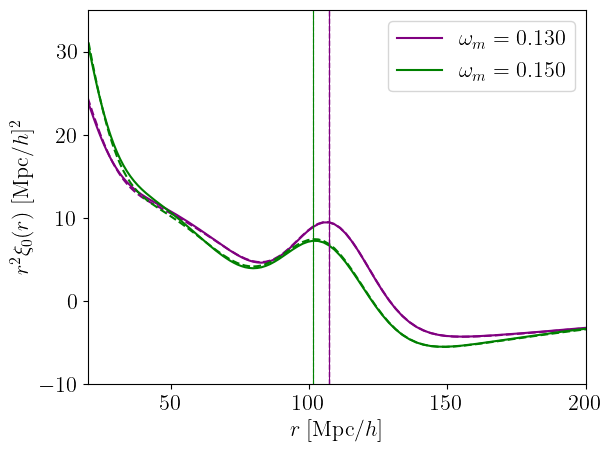

In [124]:
# Comparison for two parameters
plt.plot(s0_GAs[1][0], s0_GAs[1][0]**2*xi0_GAs[1][0], color='purple', label=f'$\omega_m = {omega_m_vals[0]:.3f}$')
plt.plot(s0_class[1][0], s0_class[1][0]**2*xi0_class[1][0], '--', color='purple')
plt.plot(s0_GAs[1][-1], s0_GAs[1][-1]**2*xi0_GAs[1][-1], color='green', label=f'$\omega_m = {omega_m_vals[-1]:.3f}$')
plt.plot(s0_class[1][-1], s0_class[1][i]**2*xi0_class[1][-1], '--', color='green')
plt.xlim(20, 200)
plt.ylim(-10, 35)
plt.xlabel(r'$r \ [\mathrm{Mpc}/h]$')
plt.ylabel(r'$r^2 \xi_0 (r) \ [\mathrm{Mpc}/h]^2$')
plt.legend()

# Add vertical line at r = 107.16
plt.axvline(x=101.39394576752917, color='green', linewidth=0.8)
plt.axvline(x=107.16676480328644, color='purple', linewidth=0.8)
plt.axvline(x=101.39394576752917, color='green', linestyle='--', linewidth=0.8)
plt.axvline(x=107.16676480328644, color='purple', linestyle='--', linewidth=1.0)

# Save the first plot as a PDF
plt.tight_layout()
plt.savefig('2PCF_comparison.pdf')

# Display the plots

plt.show()

In [123]:
peaks_GAs[1][0], properties_GAs[1][0] = find_peaks(s0_GAs[1][0]**2*xi0_GAs[1][0], height=0.5, distance=1)
peaks_GAs[1][-1], properties_GAs[1][-1] = find_peaks(s0_GAs[1][-1]**2*xi0_GAs[1][-1], height=0.5, distance=1)

peaks_class[1][0], properties_class[1][0] = find_peaks(s0_class[1][0]**2*xi0_class[1][0], height=0.5, distance=1)
peaks_class[1][-1], properties_class[1][-1] = find_peaks(s0_class[1][-1]**2*xi0_class[1][-1], height=0.5, distance=1)
        
# Print peak properties
print("GAs Peaks at:", s0_GAs[1][0][peaks_GAs[1][0]][-1])
print("GAs Peaks at:", s0_GAs[1][-1][peaks_GAs[1][-1]][-1])
print("CLASS Peaks at:", s0_class[1][0][peaks_class[1][0]][-1])
print("CLASS Peaks at:", s0_class[1][-1][peaks_class[1][-1]][-1])

GAs Peaks at: 107.16676480328655
GAs Peaks at: 101.39394576752927
CLASS Peaks at: 105.2068671023624
CLASS Peaks at: 101.39394576752927


# $2\mathrm{P}~\mathrm{Correlation~Function}$: $f(R)$

## Packages

In [1]:
import numpy as np
from classy import Class


import scipy 
from scipy import interpolate
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy.signal import find_peaks
import hankl

import math

# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 16
})

## Compute $P(k)$ from CLASS

In [2]:
# Grid of 4x4 
fR0_vals = np.array([5e-7, 5e-6, 5e-5, 5e-4])
# To store models
fR = {}

In [3]:
for i in range(len(fR0_vals)):
    # pass input parameters
    cosmo_params = {'h': 0.6711,
                    'Omega_b': 0.049, 
                    'Omega_cdm': 0.2685,
                    'n_s': 0.9624,
                    'A_s': 2.130397e-09, # sigma8 = 0.8340
                    'Omega_fld': 0,
                    'Omega_scf': 0,
                    'mg_ansatz': 'FR',
                    'F_R0': fR0_vals[i], 
                    'FRn': 1,
                    'gauge':'newtonian',
                    'output':'mPk', 
                    'P_k_max_h/Mpc': 1}
    fR[i] = Class()
    fR[i].set(cosmo_params)
    fR[i].compute()
print('Run Class... Done')

    ******************************************
       Modified Gravity extensions enabled:  
       Modifications active for z < 6.000    
       For the FR model
    ******************************************
    ******************************************
       Modified Gravity extensions enabled:  
       Modifications active for z < 6.000    
       For the FR model
    ******************************************
    ******************************************
       Modified Gravity extensions enabled:  
       Modifications active for z < 6.000    
       For the FR model
    ******************************************
    ******************************************
       Modified Gravity extensions enabled:  
       Modifications active for z < 6.000    
       For the FR model
    ******************************************
Run Class... Done


In [4]:
h = fR[0].h()
omega_b = fR[0].omega_b()
Omega_b = omega_b/h**2
Omega_m = fR[0].Omega_m()
omega_m = Omega_m*h**2
ns = fR[0].n_s()
As = 2.130397

In [5]:
# get P(k) at z = 0
kmin = 1e-4
kmax = 1
nk = 200
kk = np.logspace(np.log10(kmin), np.log10(kmax), nk)
Pk = [] # P(k) in [Mpc^3]
interpolated_Pk = []
for i in range(len(fR0_vals)):
    pk_vals = [fR[i].pk(k*h, 0.)*h**3 for k in kk]
    Pk.append(pk_vals)

    interp_fn = scipy.interpolate.interp1d(kk, pk_vals, kind='cubic', fill_value='extrapolate')
    interpolated_Pk.append(interp_fn)

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_4114216/2817009522.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathrm{CLASS}$')


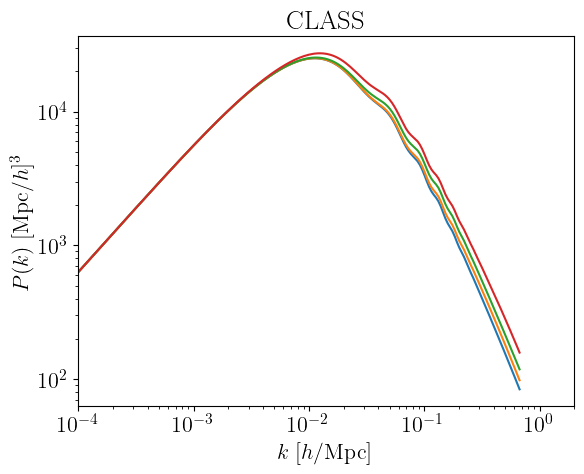

In [6]:
# plot P(k)
plt.xscale('log')
plt.yscale('log')
plt.xlim(kk[0], 2)
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \ [\mathrm{Mpc}/h]^3$')
plt.title('$\mathrm{CLASS}$')
for i in range(len(fR0_vals)):
    plt.plot(kk*h, interpolated_Pk[i](kk))
plt.show()

## Compute $P_\mathrm{MG}(k)$

In [7]:
# Constantes
c = 2998  # velocidad de la luz en unidades consistentes
kpivot = 0.05  # escala pivot

# Función A0
def A0(h, omega_m, ns, As):
    return 2 * np.pi**2 * (As * 1e-9) * (h / kpivot)**(ns - 1) * ((2 * c**2 * h**2) / (5 * omega_m))**2

# Función TGAnw (transferencia suavizada sin BAO)
def TGAnw(k, h, omega_b, omega_m):
    x = (h * k) / (omega_m - omega_b)
    return (1 + 101.855 * x**1.483 + 21112.189 * x**3.972 +
            35913.065 * x**6.097 + 1428.081 * x**7.507) ** (-0.25)

# Espectro corregido a pequeña escala
def Psmall(k, h, omega_b, omega_m, ns, As, alpha, gamma, kMG, Delta):
    transfer = TGAnw(k, h, omega_b, omega_m)
    coeff = 1 + 0.711 * alpha**3 + 1.880 * alpha**4 + 0.939 * alpha**5
    correction = 1 + gamma / (1 + (kMG / k)**Delta)
    return A0(h, omega_m, ns, As) * coeff * k**ns * transfer**2 * correction

# Espectro primordial en escalas grandes
def Plarge(k, h, omega_m, ns, As, s):
    return A0(h, omega_m, ns, As) * (1 + s) * k**ns

# Función de transición tipo sigmoid en log(k)
def sigma(k, k0, beta):
    return 1 / (1 + np.exp(-(np.log(k) - np.log(k0)) / beta))

# Espectro combinado PMG
def PMG(k, h, omega_b, omega_m, ns, As, s, k0, beta, alpha, gamma, kMG, Delta):
    sig = sigma(k, k0, beta)
    return (1 - sig) * Plarge(k, h, omega_m, ns, As, s) + sig * Psmall(k, h, omega_b, omega_m, ns, As, alpha, gamma, kMG, Delta)

In [8]:
Params_fR = [[-0.378432, 0.000679271, 0.441085, -0.372967, -0.375948, 1.8531, -1.38537],
             [-0.378394, 0.000658576, 0.44124, -0.361145, -0.376225, 0.642021, -1.25978],
             [-0.378362, 0.00138982, 0.530235, -0.21685, -0.397201, 0.239884, -1.00358],
             [-0.378255, 0.00225816, 0.511822, 0.662624, -0.675358, 0.662071, -0.625801]]

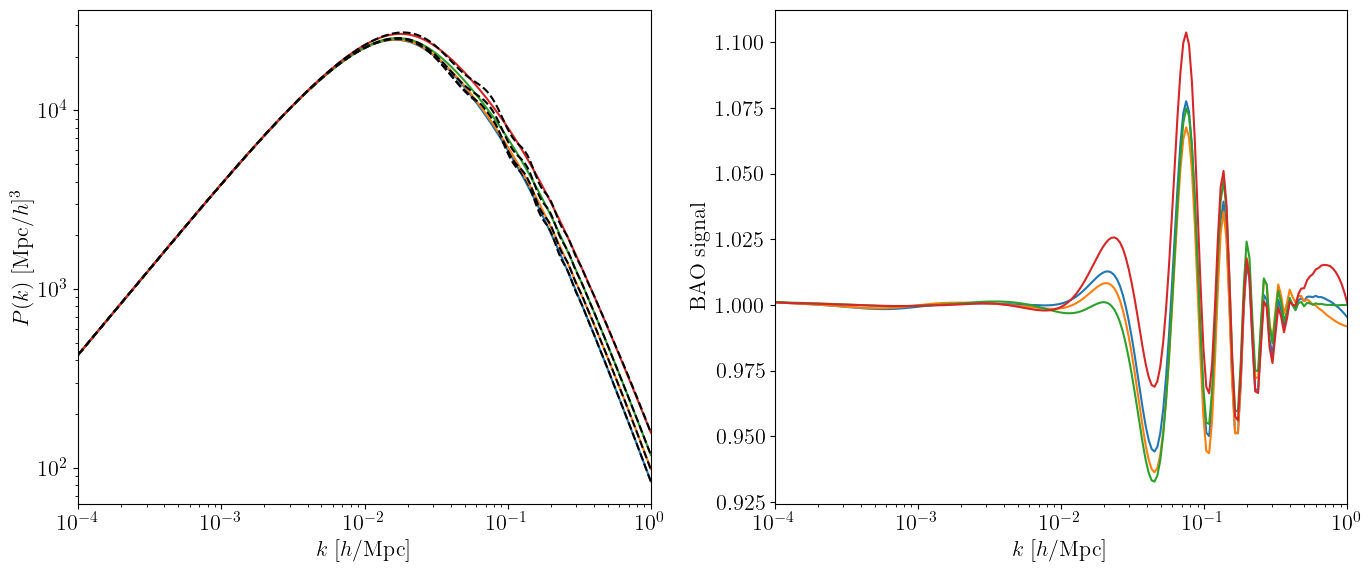

In [9]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# plot P(k)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(kk[0], 1)
ax1.set_xlabel(r'$k \ [h/\mathrm{Mpc}]$')
ax1.set_ylabel(r'$P(k) \ [\mathrm{Mpc}/h]^3$')
for i in range(len(fR0_vals)):
    ax1.plot(kk, PMG(kk, h, omega_b, omega_m, ns, As, *Params_fR[i]), '-')
    ax1.plot(kk, interpolated_Pk[i](kk), '--', color='black')

ax2.set_xscale('log')
ax2.set_xlim(kk[0], kk[-1])
ax2.set_xlabel(r'$k \ [h/\mathrm{Mpc}]$')
ax2.set_ylabel(r'$\mathrm{BAO~signal}$')
for i in range(len(fR0_vals)):
    ax2.plot(kk, interpolated_Pk[i](kk)/PMG(kk, h, omega_b, omega_m, ns, As, *Params_fR[i]), '-')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

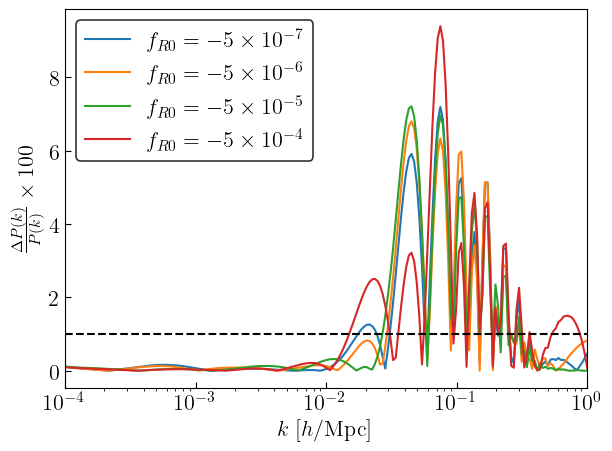

In [10]:
# Plot PGAs(k)
for i in range(len(fR0_vals)):
    plt.semilogx(kk, np.abs(1 - PMG(kk, h, omega_b, omega_m, ns, As, *Params_fR[i])/interpolated_Pk[i](kk))*100, '-')
plt.plot(kk, np.ones(len(kk)), '--', color='black')
plt.xlim(kk[0], kk[-1])
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\frac{\Delta P(k)}{P(k)} \times 100 $')

# Leyenda con título y estilo
labels = [
    r'$f_{R0} = -5 \times 10^{-7}$',
    r'$f_{R0} = -5 \times 10^{-6}$',
    r'$f_{R0} = -5 \times 10^{-5}$',
    r'$f_{R0} = -5 \times 10^{-4}$',
]

leg = plt.legend(labels, loc='upper left', fontsize=16, frameon=True)
frame = leg.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(1.2)

# Ticks dentro del marco (igual que Mathematica)
plt.tick_params(direction='in', length=4, width=0.8)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

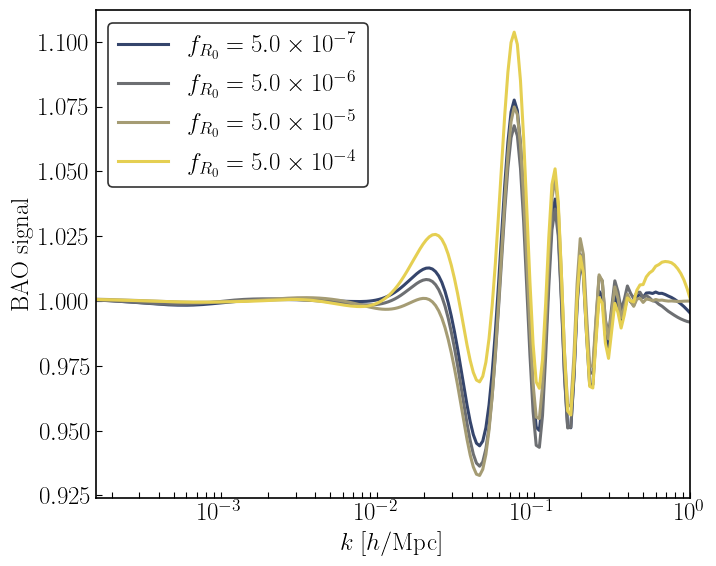

In [11]:
import matplotlib as mpl

# Estilo general de matplotlib
mpl.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'lines.linewidth': 2.2,
    'axes.linewidth': 1.2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

def sci_notation_latex(x):
    """Convierte un número como -5e-7 a una cadena LaTeX: -5 × 10^{-7}"""
    sign = '-' if x < 0 else ''
    coeff, exp = f"{abs(x):.1e}".split('e')
    return rf"{sign}{coeff} \times 10^{{{int(exp)}}}"

# Paleta de colores perceptualmente uniforme (cividis es buena opción científica)
colors = plt.get_cmap('cividis')(np.linspace(0.2, 0.9, len(fR0_vals)))

# Crear figura
plt.figure(figsize=(7.5, 6))

# Plot TGAs(k)
for i in range(len(fR0_vals)):
    plt.semilogx(
        kk,
        interpolated_Pk[i](kk) / PMG(kk, h, omega_b, omega_m, ns, As, *Params_fR[i]),
        color=colors[i],
        label=rf'$f_{{R_0}} = {sci_notation_latex(fR0_vals[i])}$'
    )

# Ejes y límites
plt.xlim(kk[10], kk[-1])
plt.xlabel(r'$k \ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\mathrm{BAO~signal}$')

# Leyenda
leg = plt.legend(loc='upper left', frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.2)

# Estilo de ticks
plt.tick_params(which='both', direction='in', length=4, width=0.8)

# Layout y guardado
plt.tight_layout()
plt.savefig("BAO_signal_fR0.pdf", format="pdf")
plt.show()


## $\xi_\text{2PT}$

In [12]:
def Olin(k, fR_index):
    Olin_calc = interpolated_Pk[fR_index](k)/PMG(k, h, omega_b, omega_m, ns, As, *Params_fR[fR_index])
    return Olin_calc

In [13]:
bias_0 = 1.0
s8_0 = []
for i in range(len(fR0_vals)):
    s8_0.append(fR[i].sigma8())
alpha_par = 1.0
alpha_trans = 1.0

In [14]:
s8_0

[0.8399754713322138,
 0.8704499196165515,
 0.9314571515024186,
 1.0126263602878254]

In [15]:
# AP correction
def kpar(k, mu):
    return k*mu/alpha_par

def kper(k, mu):
    return k*np.sqrt(1 - mu**2)/alpha_trans

#This is the k with AP included
def kap(k, mu):
    return np.sqrt(kpar(k, mu)**2 + kper(k, mu)**2)

#This is the mu with AP included
def muap(k, mu):
    return kpar(k, mu)/kap(k, mu)

def growthrate(z):
    growthrate_class = 1.0
    return growthrate_class
        
def finger(k, mu, sigmas):
    finger_calc = (1 + (k*sigmas*mu)**2)**(-1)
    return finger_calc

def fs8(z, fR_index):
    fs8_calc = s8_0[fR_index]*growthrate(z)
    return fs8_calc

In [16]:
# Zel’dovich approximation 
def sigmaxy_class(fR_index):
    kgrid1 = np.linspace(np.log(kk[0]), np.log(kk[-1]), 2**12+1)
    dk = np.diff(kgrid1)[0] 
    I1 = np.cumsum(dk*np.exp(kgrid1)*interpolated_Pk[fR_index](np.exp(kgrid1)))
    sigmaxy_calc = s8_0[fR_index]*np.sqrt(I1[-1]/(2*np.pi**2))
    return sigmaxy_calc

def sigmaz_class(z, fR_index): 
    sigmaz_calc = (1+growthrate(z))*sigmaxy_class(fR_index)
    return sigmaz_calc

def sigmanl_class(z, fR_index):
    sigmanl_calc = np.sqrt(2/3*sigmaxy_class(fR_index)**2 + 1/3*sigmaz_class(z, fR_index)**2)
    return sigmanl_calc

def expgmu_class(k, fR_index):
    expgmu_calc = np.exp(-0.5* sigmanl_class(0, fR_index)**2*k**2)    
    return expgmu_calc

In [17]:
def pksmooth_class(k, mu, sigmas, fR_index):
    rsmooth = 15
    recon = 1 - np.exp(-0.5*(k*rsmooth)**2)
    kaiser = (s8_0[fR_index]*bias_0 + fs8(0, fR_index)*recon*mu**2)**2
    fog = finger(k, mu, sigmas)
    pksmooth_calc = kaiser*fog*PMG(k, h, omega_b, omega_m, ns, As, *Params_fR[fR_index])
    return pksmooth_calc

#The observed Galaxy power spectrum
def pobs_class(k, mu, sigmas, fR_index):
    term = 1 + (Olin(kap(k, mu), fR_index) - 1)*expgmu_class(kap(k, mu), fR_index)
    pobs_class_calc = pksmooth_class(kap(k, mu), muap(k, mu), sigmas, fR_index)*term
    return pobs_class_calc

In [18]:
n_step_mu_int = 16
n_step_k_int = n_step_mu_int
k_range = np.logspace(np.log10(10**-3), np.log10(10), 500)

def pkell_0_1_class(k, sigmas, fR_index):
    mugrid1 = np.linspace(-1, 1, 2**n_step_mu_int+1)
    dmu = np.diff(mugrid1)[0]
    pobsgrid = pobs_class(k, mugrid1, sigmas, fR_index)
    I1 = np.cumsum(dmu*pobsgrid)
    pkell_0_1_class_calc = I1[-1]/2
    return pkell_0_1_class_calc

pkell_0_class = np.vectorize(pkell_0_1_class)

s0_class = []
xi0_class = []

for i in range(len(fR0_vals)):
    pk = pkell_0_class(k_range, 0, i)
    s0, xi0 = hankl.P2xi(k_range, pk, l=0)
    s0_class.append(s0)
    xi0_class.append(xi0)

In [19]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

r_max_list = []
xi_max_list = []

for i in range(len(fR0_vals)):
    r_vals = s0_class[i]
    xi_vals = r_vals**2 * xi0_class[i]

    # Interpolation
    f_interp = interp1d(r_vals, xi_vals, kind='cubic', bounds_error=False, fill_value='extrapolate')

    # Maximum on the bound
    res = minimize_scalar(lambda r: -f_interp(r), bounds=(90, 110), method='bounded')
    
    r_max_list.append(res.x)
    xi_max_list.append(-res.fun)

    print(f"fR[{i}]: Max at r = {res.x:.2f}")

fR[0]: Max at r = 102.33+0.00j
fR[1]: Max at r = 102.22+0.00j
fR[2]: Max at r = 102.09+0.00j
fR[3]: Max at r = 101.72+0.00j


/home/bayron/anaconda3/lib/python3.12/site-packages/scipy/interpolate/_bsplines.py:491: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.ascontiguousarray(x.ravel(), dtype=np.float64)


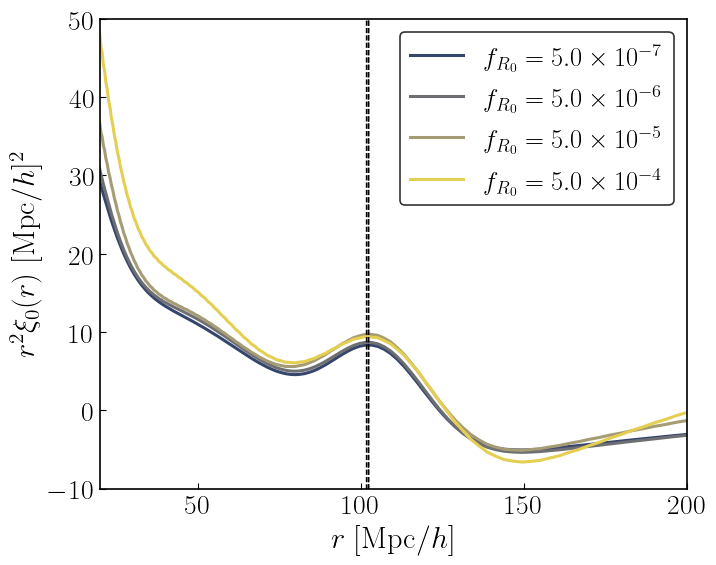

In [34]:
# Función para convertir a notación científica estilo LaTeX
def sci_notation_latex(x):
    sign = '-' if x < 0 else ''
    coeff, exp = f"{abs(x):.1e}".split('e')
    return rf"{sign}{coeff} \times 10^{{{int(exp)}}}"

# Estilo general de matplotlib
mpl.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 22,
    'axes.titlesize': 19,
    'legend.fontsize': 19,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'lines.linewidth': 2.2,
    'axes.linewidth': 1.2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

# Colores para las curvas
colors = plt.get_cmap('cividis')(np.linspace(0.2, 0.9, len(fR0_vals)))

# Figura
plt.figure(figsize=(7.5, 6))

# Plot r^2 xi_0(r)
for i in range(len(fR0_vals)):
    plt.plot(
        s0_class[i],
        s0_class[i]**2 * xi0_class[i],
        color=colors[i],
        label=rf'$f_{{R_0}} = {sci_notation_latex(fR0_vals[i])}$'
    )

# Límites y etiquetas
plt.xlim(20, 200)
plt.ylim(-10, 50)
plt.xlabel(r'$r \ [\mathrm{Mpc}/h]$')
plt.ylabel(r'$r^2 \xi_0 (r) \ [\mathrm{Mpc}/h]^2$')

# Líneas verticales (picos BAO)
for x in [102.33, 102.22, 102.09, 101.72]:
    plt.axvline(x=x, linestyle='--', linewidth=1, color='black')

# Leyenda
leg = plt.legend(loc='upper right', frameon=True)
frame = leg.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(1.2)

# Ticks estilo Mathematica
plt.tick_params(which='both', length=4, width=0.8)

# Layout final y guardado
plt.tight_layout()
plt.savefig("r2_xi0_fR0.pdf", format="pdf")
plt.show()


In [ ]:
# Comparison for two parameters
plt.plot(s0_GAs[1][0], s0_GAs[1][0]**2*xi0_GAs[1][0], color='purple', label=f'$\omega_m = {omega_m_vals[0]:.3f}$')
plt.plot(s0_class[1][0], s0_class[1][0]**2*xi0_class[1][0], '--', color='purple')
plt.plot(s0_GAs[1][-1], s0_GAs[1][-1]**2*xi0_GAs[1][-1], color='green', label=f'$\omega_m = {omega_m_vals[-1]:.3f}$')
plt.plot(s0_class[1][-1], s0_class[1][i]**2*xi0_class[1][-1], '--', color='green')
plt.xlim(20, 200)
plt.ylim(-10, 35)
plt.xlabel(r'$r \ [\mathrm{Mpc}/h]$')
plt.ylabel(r'$r^2 \xi_0 (r) \ [\mathrm{Mpc}/h]^2$')
plt.legend()

# Add vertical line at r = 107.16
plt.axvline(x=101.39394576752917, color='green', linewidth=0.8)
plt.axvline(x=107.16676480328644, color='purple', linewidth=0.8)
plt.axvline(x=103.28281259410296, color='green', linestyle='--', linewidth=0.8)
plt.axvline(x=107.16676480328644, color='purple', linestyle='--', linewidth=1.0)

# Save the first plot as a PDF
plt.tight_layout()
plt.savefig('2PCF_comparison.pdf')

# Display the plots

plt.show()